# Initialization (Same as Retrieval Notebook)

## Installation of packages

In [1]:
# Required installations
!pip install transformers sentence-transformers faiss-cpu torch accelerate bitsandbytes autoawq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver doe

## Imports

In [2]:
import torch
from torch import cuda, bfloat16
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
import faiss
import pickle
import numpy as np
import os

# Mount Google Drive (This may require manual approval for connection with Google Drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Defining paths to Google Drive

In [3]:
# Define paths for your Google Drive files
DRIVE_PATH = "/content/drive/MyDrive/DLProject"  # Base folder in Drive
INDEX_PATH = os.path.join(DRIVE_PATH, "qa_faiss_index.index")
PROCESSED_DATA_PATH = os.path.join(DRIVE_PATH, "processed_data.pkl")

# Verify files exist
if not os.path.exists(INDEX_PATH) or not os.path.exists(PROCESSED_DATA_PATH):
    raise FileNotFoundError("Required files not found in the specified directory.")

## Huggingface Access Token

How to get & prepare HF_TOKEN:
1. Log in to huggingface
2. Create a token here: https://huggingface.co/settings/tokens (Read-Only)
3. Copy the Value from there. Ek dafa aayegi sirf so copy it there and then
4. You need to click on the key icon to the left and place your token there under the name 'HF_TOKEN'. Name and Value as it is written on the Hugging Face Website
5. Allow access for that token to this notebook

## Loading Embeddings

In [4]:
# Load embedding model
embeddings_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
print("Embedding model loaded!")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding model loaded!


In [5]:
# Load FAISS index
index = faiss.read_index(INDEX_PATH)
print("FAISS index loaded!")
# Load processed documents
print("Loading processed data...")
with open(PROCESSED_DATA_PATH, 'rb') as f:
    data = pickle.load(f)
    documents = data['documents']
    questions = data['questions']
print("Processed data loaded!")
print(f"Documents: {len(documents)}")
print(f"Questions: {len(questions)}")
print(documents)

FAISS index loaded!
Loading processed data...
Processed data loaded!
Documents: 732
Questions: 732
["The Office of Academic Systems and Registrar (RO) is responsible for handling class schedules and course enrollment at Habib University. If you encounter any issues with scheduling or enrollment, you can visit the Registrar's Office at the Student Center or email them at registrar-office@habib.edu.pk.", 'If you face any problems with your class schedule, you can drop by the Registrar’s Office in the Student Center or reach out via email at registrar-office@habib.edu.pk for help.', "The Registrar's Office is located in the Student Center at Habib University. You can visit them in person if you face any issues related to class schedules or enrollment.", "If you're unable to visit the Registrar's Office in person, you can email them at registrar-office@habib.edu.pk for assistance with course scheduling or any other academic issue.", "You can contact the Registrar's Office either by visitin

# Answer Generation

## Meta/HuggingFace approval

1. Go to this URL
https://huggingface.co/meta-llama/Llama-3.2-1B
2. Scroll Down and see the form.
3. Fill out your information
4. Wait for your request to get approved
5. Create a Fine-Grained token
6. Add that to the secrets

## Model preparation (Llama 3.2 1B Instruct)

In [6]:
# Initialize model
model_id = "meta-llama/Llama-3.2-1B-Instruct" # The model identifier from Hugging Face's model hub.
# If GPU is available it will run on
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16, # Specify the data type for the model's weights (bfloat16 for efficiency).
    device_map="auto" # Automatically assign the model to the appropriate device (GPU if available, otherwise CPU).
)

print("Llama-3.2-1B Loaded!")

tokenizer = AutoTokenizer.from_pretrained(
    model_id
)
print("Tokenizer Loaded!")


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Llama-3.2-1B Loaded!


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Tokenizer Loaded!


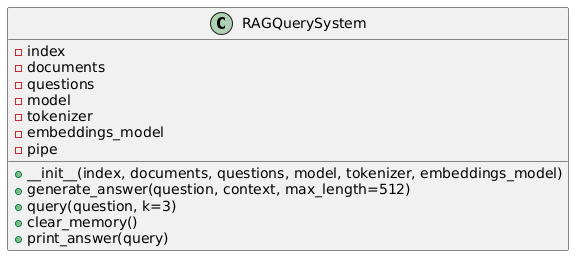

## RAG class

In [7]:
class RAGQuerySystem:
  """This is a class which is used for communication between the models. RAG foundation."""

  def __init__(self, index, documents, questions, model, tokenizer, embeddings_model):
      self.index = index #he FAISS index used for searching.
      self.documents = documents #The list of Answers used for retrieval.
      self.questions = questions #The list of questions corresponding to the documents.
      self.model = model
      self.tokenizer = tokenizer
      self.embeddings_model = embeddings_model
      # Hugging Face Pipepline
      self.pipe = pipeline("text-generation",
                           model=model,
                           tokenizer=tokenizer,
                           torch_dtype=torch.bfloat16, # Set the data type for the model's weights to bfloat16 for efficiency.
                           device_map="auto", #GPU if Availlable, else CPU
                           max_new_tokens=512)

  def generate_answer(self, question, context, max_length=512):
      #This is a part where you can edit your prompt, context provides 3 most relevant informations from the vector store and question forwards the question
      prompt = f"""You are HU assistant for new students. Answer using ONLY facts explicitly stated in this context:
      "{context}"

      If something isn't directly stated in the context, do not include it.
      Avoid repeating yourself.

      Question: "{question}"

      Answer what is directly stated in the context, additional information is not required. Your answer can be pure text.

      Answer:"""

      response = self.pipe(
        prompt,
        max_new_tokens=max_length,
        do_sample=True,
        temperature=0.1,        # Lower temperature for more focused responses
        top_p=0.9,           # Add top_p to reduce repetition
        repetition_penalty=1.2  # Add repetition penalty
      )

      response = response[0]["generated_text"]

      # This model replicates whole prompt before answering, which is why this bottom line splits the full answer
      answer = response.split("Answer:")[-1].strip()
      return answer

  def query(self, question, k=3):

      # Get question embedding
      question_embedding = self.embeddings_model.encode([question], convert_to_tensor=True)
      if device != "cpu":
        question_embedding = question_embedding.cpu()

      # Search in FAISS
      distances, indices = self.index.search(question_embedding, k) #Indices of Top K Retrieved

      # Get relevant documents
      relevant_docs = [f"{self.documents[i]}" for i in indices[0]] #Top 3 Indices for Answers (Documents) lst
      context = "\n".join(relevant_docs)

      # Get QA
      qa = [f"Q: {self.questions[i]} A: {self.documents[i]}" for i in indices[0]]

      # Generate answer
      answer = self.generate_answer(question, context)

      return {
          'answer': answer,
          'relevant_documents': relevant_docs,
          'distances': distances[0],
          'qa': qa
      }

  def clear_memory(self):
      torch.cuda.empty_cache()
      import gc
      gc.collect()

  def print_answer(self, query):
      result = self.query(test_question)
      print(f"\n=== User Query ===\n{query}")
      print(f"\n=== Q&A ===")
      for (i, qa) in enumerate(result['qa']):
        print(f"{i+1}. {qa}")
      print(f"\n=== Generated Answer ===\n{result['answer']}")
      self.clear_memory()

### Instantiating

In [8]:
# Initialize the RAG system
rag_system_1B = RAGQuerySystem(index, documents, questions, model, tokenizer, embeddings_model)

In [9]:
def format_response(result):
    """For answer structure"""
    print("\n=== Generated Answer ===")
    print(result['answer'])
    print("\n=== Source Documents ===")
    for i, (doc, dist) in enumerate(zip(result['relevant_documents'], result['distances']), 1):
        print(f"\nSource {i} (Relevance Score: {1/(1+dist):.4f}):")
        print(doc)

# Interactive query function
def interactive_query(rag_system):
    while True:
        question = input("\nEnter your question (or 'quit' to exit): ")
        if question.lower() == 'quit':
            rag_system.clear_memory()
            break
        else:
            result = rag_system.query(question)
            format_response(result)

## Test cell

In [10]:
# Run test query
test_question = "What are the timings for the HU swimming pool?"
rag_system_1B.print_answer(test_question)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== User Query ===
What are the timings for the HU swimming pool?

=== Q&A ===
1. Q: What are the timings for male and female students to use the HU swimming pool? A: The HU swimming pool has separate schedules for male and female students:  Female Members: Monday, Wednesday, and Friday Male Members: Tuesday, Thursday, and Saturday
2. Q: What are the pool days and timings at Habib University? A: The pool is available on separate days for male and female students, with different timings:  Female: Monday, Wednesday, and Friday Male: Tuesday, Thursday, and Saturday  The pool timings are as follows:  Students: 11:00 AM – 05:00 PM Faculty: 11:30 AM – 07:30 PM Staff: 05:00 PM – 07:30 PM Alumni: 05:00 PM – 07:30 PM Working Saturday: 11:30 AM – 07:30 PM Non-working Saturday: 11:30 AM – 06:00 PM
3. Q: Are there any special fitness programs available at the HU swimming pool? A: Yes, the HU swimming pool offers special fitness programs for new swimmers. These programs focus on teaching basic swi

## Interactive Session


In [16]:
# Start interactive session
print("\n=== Starting Interactive Session ===")
print("Type your questions or 'quit' to exit")
interactive_query(rag_system_1B)


=== Starting Interactive Session ===
Type your questions or 'quit' to exit

Enter your question (or 'quit' to exit): What are swiming Pool timings?


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== Generated Answer ===
Swimming Pool Timings:

    - Student (Female): Monday, Wednesday, Friday; 5:00-7:30PM
    - Student (Male): Tuesday, Thursday, Saturday; 6:00-8:30AM

     Note that working Saturdays have a later closing time of 07:30PM

=== Source Documents ===

Source 1 (Relevance Score: 0.5366):
The pool is available on separate days for male and female students, with different timings:  Female: Monday, Wednesday, and Friday Male: Tuesday, Thursday, and Saturday  The pool timings are as follows:  Students: 11:00 AM – 05:00 PM Faculty: 11:30 AM – 07:30 PM Staff: 05:00 PM – 07:30 PM Alumni: 05:00 PM – 07:30 PM Working Saturday: 11:30 AM – 07:30 PM Non-working Saturday: 11:30 AM – 06:00 PM

Source 2 (Relevance Score: 0.5260):
The HU swimming pool has separate schedules for male and female students:  Female Members: Monday, Wednesday, and Friday Male Members: Tuesday, Thursday, and Saturday

Source 3 (Relevance Score: 0.4845):
Yes, the HU swimming pool offers special fitness p

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== Generated Answer ===
The Registrar's Office is located in the Student Center at Habib University.

=== Source Documents ===

Source 1 (Relevance Score: 0.5286):
The Registrar's Office is located in the Student Center at Habib University. You can visit them in person if you face any issues related to class schedules or enrollment.

Source 2 (Relevance Score: 0.4907):
Submit a Change of Program/School Request Form to the Office of Academic Systems & Registrar.

Source 3 (Relevance Score: 0.4432):
For technical support related to your HU email, ID card, or PeopleSoft, you can visit the User Computing and Information Technology Department located on the ground floor near the library. You can also reach out via email for assistance.

Enter your question (or 'quit' to exit): Where can I eat?


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== Generated Answer ===
Habib offers a range of dining options, including Tapal Cafeteria, Hobnob, Sky Dhabba, Cafe2Go, and Raheem Bhai Fries stall.

=== Source Documents ===

Source 1 (Relevance Score: 0.4607):
Habib offers a range of dining options, including Tapal Cafeteria, Hobnob, Sky Dhabba, Cafe2Go, and Raheem Bhai Fries stall. You can also choose from various meal plans, depending on your dietary preferences and needs.

Source 2 (Relevance Score: 0.4519):
No, you cannot eat food in the library or bring it. However, drinks with a lid or packed food are allowed inside. Eating and drinking are only permitted on the ground floor.

Source 3 (Relevance Score: 0.4258):
No, food and beverages are not allowed in the Maker Space. Clean up your area and return stationery to the trolley when your project is finished.

Enter your question (or 'quit' to exit): Can I plaly at Yohsin?


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== Generated Answer ===
No

=== Source Documents ===

Source 1 (Relevance Score: 0.5017):
YOHSIN values include striving for excellence, appreciating aesthetics, nurturing passion, respecting others, and serving the community.

Source 2 (Relevance Score: 0.4909):
Students are encouraged to incorporate the YOHSIN values in their academic work and personal interactions. This includes being responsible, respectful, passionate, and contributing positively to both the university and society.

Source 3 (Relevance Score: 0.4695):
Yes, YOHSIN Scholars must complete A Levels with no grades less than A in any subject. If this requirement is not met, the scholarship will be reduced to 80%. Recipients of Excellence and Merit Scholarships should complete three A Level subjects with an average of C and no grade lower than D. Failure to meet this requirement will result in the withdrawal of the scholarship.

Enter your question (or 'quit' to exit): How to borrow a book?


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== Generated Answer ===
To borrow a book, go to the circulation counter and ask if they have any items that match yours.

=== Source Documents ===

Source 1 (Relevance Score: 0.6950):
To borrow books, take them with your ID Card to the circulation counter on the first floor. The staff will facilitate the lending process.

Source 2 (Relevance Score: 0.5299):
If an item is not available in the existing library collection (print book or online article), the library will attempt to borrow it from another library within the city through an ‘Inter-Library Loan’ arrangement. Call 5524 or 5523 for further assistance or email library@habib.edu.pk.

Source 3 (Relevance Score: 0.5140):
If no one has reserved or requested the book(s) you have borrowed, you can renew once by asking staff at the first-floor circulation counter. Books returned after the due date will not be renewed for a week.

Enter your question (or 'quit' to exit): quit


In [12]:
import json
import nltk
from nltk.translate.bleu_score import sentence_bleu
import os

# Download necessary NLTK data
nltk.download('punkt_tab') # Download 'punkt_tab' instead of just 'punkt'

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [13]:
# Evaluation

def calculate_bleu(generated_answer, expected_answer):
    """Calculates the BLEU score between a generated answer and an expected answer."""
    reference = nltk.word_tokenize(expected_answer)  # Tokenize the expected answer
    candidate = nltk.word_tokenize(generated_answer)  # Tokenize the generated answer
    return sentence_bleu([reference], candidate)  # Calculate BLEU score

# Load test data
with open(os.path.join(DRIVE_PATH, 'test_data_100.json'), 'r') as f:
    test_data = json.load(f)

# Initialize variables to store total and average BLEU scores
total_bleu = 0
average_bleu = 0

# Loop through test data, calculate BLEU score for each question-answer pair
for data_point in test_data:
    question = data_point['question']
    expected_answer = data_point['answer']
    result = rag_system_1B.query(question)  # Replace with your RAG system object
    generated_answer = result['answer']

    # Calculate BLEU score and add to total
    bleu_score = calculate_bleu(generated_answer, expected_answer)
    total_bleu += bleu_score

# Calculate average BLEU score
average_bleu = total_bleu / len(test_data)

# Print the average BLEU score
print(f"Average BLEU Score: {average_bleu:.4f}")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None 

Average BLEU Score: 0.1343


In [14]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=07c5cdb5f76925c1c1d08b2af4845492e2752d5cbd7f4f8d515552ddfb92aa10
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [17]:
from rouge_score import rouge_scorer
# Load test data
with open(os.path.join(DRIVE_PATH, 'test_data_100.json'), 'r') as f:
    test_data = json.load(f)

# Initialize the RougeScorer object
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Initialize variable to store total ROUGE-1 scores
total_rouge_1_f1 = 0

# Loop through test data, calculate ROUGE score for each question-answer pair
for data_point in test_data:
    question = data_point['question']
    expected_answer = data_point['answer']
    result = rag_system_1B.query(question)
    generated_answer = result['answer']

    # Calculate ROUGE scores
    scores = scorer.score(generated_answer, expected_answer)

    # Access and accumulate the ROUGE-1 F1 score
    rouge_1_f1_score = scores['rouge1'].fmeasure  # Access rouge1 instead of rougeL
    total_rouge_1_f1 += rouge_1_f1_score

# Calculate average ROUGE-1 F1 score
average_rouge_1_f1 = total_rouge_1_f1 / len(test_data)

# Print the average ROUGE-1 F1 score
print(f"Average ROUGE-1 Score: {average_rouge_1_f1:.4f}")


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

Average ROUGE-1 Score: 0.3846


## Attempting With 3B Variant

In [18]:
#Initialize model
print("Loading Llama-3.2-3B...")
model_id = "meta-llama/Llama-3.2-3B-Instruct"

#If GPU is available it will run on
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

model_3B = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
print("Model Initialized")
tokenizer_3B = AutoTokenizer.from_pretrained(
    model_id
)
print("Tokenizer Done.")

Loading Llama-3.2-3B...


config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Model Initialized


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Tokenizer Done.


In [19]:
rag_system_3B = RAGQuerySystem(index, documents, questions, model_3B, tokenizer_3B, embeddings_model)

## Testing

In [20]:
# Run test query
test_question = "What are the timings for the HU swimming pool?"
rag_system_3B.print_answer(test_question)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== User Query ===
What are the timings for the HU swimming pool?

=== Q&A ===
1. Q: What are the timings for male and female students to use the HU swimming pool? A: The HU swimming pool has separate schedules for male and female students:  Female Members: Monday, Wednesday, and Friday Male Members: Tuesday, Thursday, and Saturday
2. Q: What are the pool days and timings at Habib University? A: The pool is available on separate days for male and female students, with different timings:  Female: Monday, Wednesday, and Friday Male: Tuesday, Thursday, and Saturday  The pool timings are as follows:  Students: 11:00 AM – 05:00 PM Faculty: 11:30 AM – 07:30 PM Staff: 05:00 PM – 07:30 PM Alumni: 05:00 PM – 07:30 PM Working Saturday: 11:30 AM – 07:30 PM Non-working Saturday: 11:30 AM – 06:00 PM
3. Q: Are there any special fitness programs available at the HU swimming pool? A: Yes, the HU swimming pool offers special fitness programs for new swimmers. These programs focus on teaching basic swi

### Output Slightly Different

## Evaluations to Check Lexical Similarity

In [21]:
import json
import os

# Evaluation

def calculate_bleu(generated_answer, expected_answer):
    """Calculates the BLEU score between a generated answer and an expected answer."""
    reference = nltk.word_tokenize(expected_answer)  # Tokenize the expected answer
    candidate = nltk.word_tokenize(generated_answer)  # Tokenize the generated answer
    return sentence_bleu([reference], candidate)  # Calculate BLEU score

# Load test data
with open(os.path.join(DRIVE_PATH, 'test_data_100.json'), 'r') as f:
    test_data = json.load(f)

# Initialize variables to store total and average BLEU scores
total_bleu = 0
average_bleu = 0

# Loop through test data, calculate BLEU score for each question-answer pair
for data_point in test_data:
    question = data_point['question']
    expected_answer = data_point['answer']
    result = rag_system_3B.query(question)  # Replace with your RAG system object
    generated_answer = result['answer']

    # Calculate BLEU score and add to total
    bleu_score = calculate_bleu(generated_answer, expected_answer)
    total_bleu += bleu_score

# Calculate average BLEU score
average_bleu = total_bleu / len(test_data)

# Print the average BLEU score
print(f"Average BLEU Score: {average_bleu:.4f}")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

Average BLEU Score: 0.1494


In [22]:
from rouge_score import rouge_scorer

In [23]:
# Load test data
with open(os.path.join(DRIVE_PATH, 'test_data_100.json'), 'r') as f:
    test_data = json.load(f)

# Initialize the RougeScorer object
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Initialize variable to store total ROUGE-1 scores
total_rouge_1_f1 = 0

# Loop through test data, calculate ROUGE score for each question-answer pair
for data_point in test_data:
    question = data_point['question']
    expected_answer = data_point['answer']
    result = rag_system_3B.query(question)
    generated_answer = result['answer']

    # Calculate ROUGE scores
    scores = scorer.score(generated_answer, expected_answer)

    # Access and accumulate the ROUGE-1 F1 score
    rouge_1_f1_score = scores['rouge1'].fmeasure  # Access rouge1 instead of rougeL
    total_rouge_1_f1 += rouge_1_f1_score

# Calculate average ROUGE-1 F1 score
average_rouge_1_f1 = total_rouge_1_f1 / len(test_data)

# Print the average ROUGE-1 F1 score
print(f"Average ROUGE-1 Score: {average_rouge_1_f1:.4f}")


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

Average ROUGE-1 Score: 0.3871


## Interactive Testing


In [24]:
# Start interactive session
print("\n=== Starting Interactive Session ===")
print("Type your questions or 'quit' to exit")
interactive_query(rag_system_3B)


=== Starting Interactive Session ===
Type your questions or 'quit' to exit

Enter your question (or 'quit' to exit): Where is Registrar's Office?


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== Generated Answer ===
The Registrar's Office is located in the Student Center at Habib University.

=== Source Documents ===

Source 1 (Relevance Score: 0.5286):
The Registrar's Office is located in the Student Center at Habib University. You can visit them in person if you face any issues related to class schedules or enrollment.

Source 2 (Relevance Score: 0.4907):
Submit a Change of Program/School Request Form to the Office of Academic Systems & Registrar.

Source 3 (Relevance Score: 0.4432):
For technical support related to your HU email, ID card, or PeopleSoft, you can visit the User Computing and Information Technology Department located on the ground floor near the library. You can also reach out via email for assistance.

Enter your question (or 'quit' to exit): What are Swimming Pool Timings?


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== Generated Answer ===
- For Female members: Monday, Wednesday, and Friday from 11:00 AM – 05:00 PM
    - For Male members: Tuesday, Thursday, and Saturday from 11:00 AM – 05:00 PM (same timing)
    - For working Saturdays: From 11:30 AM – 07:30 PM
    - For non-working Saturdays: From 11:30 AM – 06:00 PM

=== Source Documents ===

Source 1 (Relevance Score: 0.5409):
The pool is available on separate days for male and female students, with different timings:  Female: Monday, Wednesday, and Friday Male: Tuesday, Thursday, and Saturday  The pool timings are as follows:  Students: 11:00 AM – 05:00 PM Faculty: 11:30 AM – 07:30 PM Staff: 05:00 PM – 07:30 PM Alumni: 05:00 PM – 07:30 PM Working Saturday: 11:30 AM – 07:30 PM Non-working Saturday: 11:30 AM – 06:00 PM

Source 2 (Relevance Score: 0.5274):
The HU swimming pool has separate schedules for male and female students:  Female Members: Monday, Wednesday, and Friday Male Members: Tuesday, Thursday, and Saturday

Source 3 (Relevance Sco

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== Generated Answer ===
The following places offer eating options:

Tapal Cafeteria
Hobnob
Sky Dhabba
Cafe2Go
Raheem Bhai Fries stall

=== Source Documents ===

Source 1 (Relevance Score: 0.4607):
Habib offers a range of dining options, including Tapal Cafeteria, Hobnob, Sky Dhabba, Cafe2Go, and Raheem Bhai Fries stall. You can also choose from various meal plans, depending on your dietary preferences and needs.

Source 2 (Relevance Score: 0.4519):
No, you cannot eat food in the library or bring it. However, drinks with a lid or packed food are allowed inside. Eating and drinking are only permitted on the ground floor.

Source 3 (Relevance Score: 0.4258):
No, food and beverages are not allowed in the Maker Space. Clean up your area and return stationery to the trolley when your project is finished.

Enter your question (or 'quit' to exit): Can I Play in Yohsin?


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== Generated Answer ===
No information about playing or participating in activities is provided in the given context.

=== Source Documents ===

Source 1 (Relevance Score: 0.4804):
YOHSIN values include striving for excellence, appreciating aesthetics, nurturing passion, respecting others, and serving the community.

Source 2 (Relevance Score: 0.4713):
Students are encouraged to incorporate the YOHSIN values in their academic work and personal interactions. This includes being responsible, respectful, passionate, and contributing positively to both the university and society.

Source 3 (Relevance Score: 0.4577):
Yes, YOHSIN Scholars must complete A Levels with no grades less than A in any subject. If this requirement is not met, the scholarship will be reduced to 80%. Recipients of Excellence and Merit Scholarships should complete three A Level subjects with an average of C and no grade lower than D. Failure to meet this requirement will result in the withdrawal of the scholarship.



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



=== Generated Answer ===
Take the book to the circulation counter on the first floor and show your ID card."

=== Source Documents ===

Source 1 (Relevance Score: 0.6950):
To borrow books, take them with your ID Card to the circulation counter on the first floor. The staff will facilitate the lending process.

Source 2 (Relevance Score: 0.5299):
If an item is not available in the existing library collection (print book or online article), the library will attempt to borrow it from another library within the city through an ‘Inter-Library Loan’ arrangement. Call 5524 or 5523 for further assistance or email library@habib.edu.pk.

Source 3 (Relevance Score: 0.5140):
If no one has reserved or requested the book(s) you have borrowed, you can renew once by asking staff at the first-floor circulation counter. Books returned after the due date will not be renewed for a week.

Enter your question (or 'quit' to exit): quit


### Making Minor Mistakes and generates extra not needed information

## Attempting with Mistral 7B

In [25]:
!pip install autoawq==0.1.8


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.9/234.9 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.8/166.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Model Preperatation (Same as Previous)

In [26]:
# Initialize model
model_id = "TheBloke/Mistral-7B-Instruct-v0.2-AWQ"

# If GPU is available it will run on
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

model_M = AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    device_map="cuda:0"
)
print("Model Loaded")

tokenizer_M = AutoTokenizer.from_pretrained(
    model_id
)
print("Tokenizer Loaded")

streamer_M = TextStreamer(tokenizer_M, skip_prompt=True, skip_special_tokens=True)

config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.15G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Model Loaded


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Tokenizer Loaded


NameError: name 'TextStreamer' is not defined

### Not working due to Library issues
